<a href="https://colab.research.google.com/github/MJ199999/SW-Project/blob/master/mini_gpt_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import re
import string
import random

In [ ]:
import pandas as pd
df = pd.read_excel("https://github.com/MJ199999/SW-Project/raw/master/poem_key.xlsx")

line_num = 0
word_num = 0
hist_word_num = []
df_poem = df['시']
for i in range(0, len(df_poem)):
  poem = df_poem.iloc[i] # 시 하나 들고오기
  line = poem.splitlines() # 그 시를 행 기준으로 나눠서 리스트로 저장
  for j in range(0, len(line)): # 연 나누는 빈 줄 세기
    stanza_num = 0
    b = (line[j] == '')
    stanza_num += b
  line_num += (len(line)-stanza_num) # 행 개수를 센다. 연 간의 빈 라인까지 합하기 때문에 이거 빼줘야 함.
  p_str = ' '.join(line) # line를 다시 문자열로 만들어준다.
  word_num += len(p_str.split()) # 시의 전체 단어 개수 센다. 
  # 히스토그램 그리기 위해 계산 코드
  for k in range(0, len(line)):
    hist_word_num.append(len(line[k].split()))
word_per_line = word_num/line_num # 단어 개수 / 행 개수 = 각 행당 평균 단어 개수
print("문장 당 평균 길이:", word_per_line)

문장 당 평균 길이: 3.9882862644415917


In [ ]:
plt_word_num = pd.DataFrame(hist_word_num)

In [ ]:
plt_word_num = plt_word_num.rename(columns={0: '1번'})

Text(0.5, 0, '행 당 단어 개수')

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54665 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45817 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45800 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50612 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_

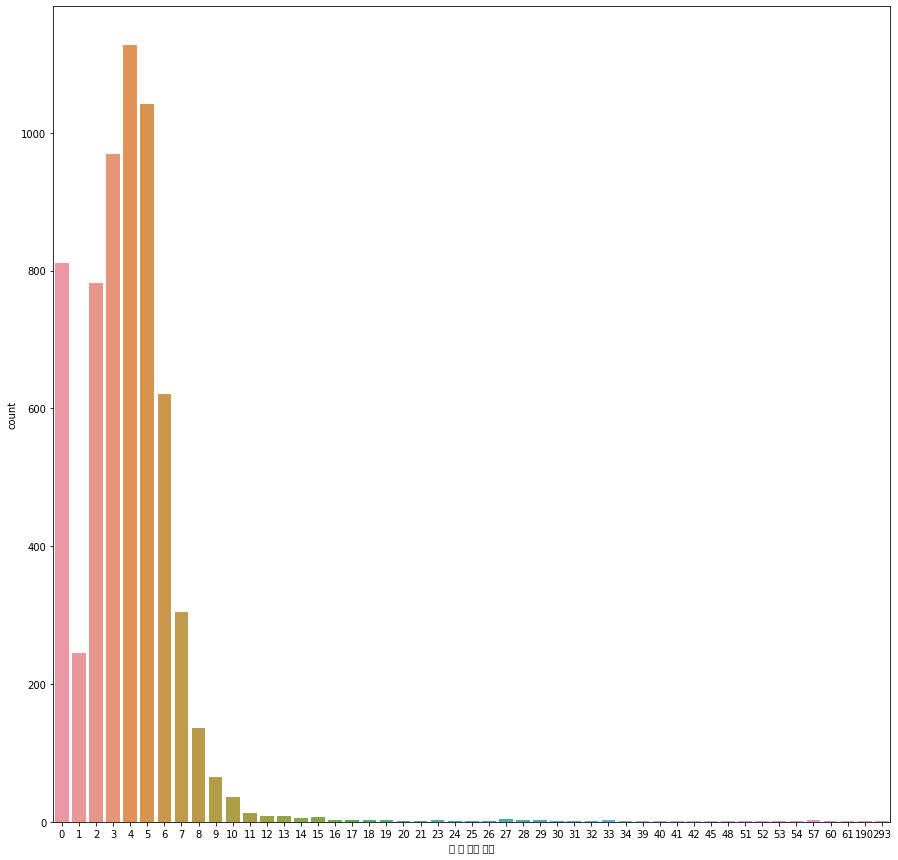

In [ ]:
ax = plt.subplots(figsize=(15, 15))
ax = sns.countplot(x='1번', data=plt_word_num)
ax.set_xlabel('행 당 단어 개수')

# 시 하나 당 단어 수 세보자

In [ ]:
for i in range(0, len(df_poem)):
  word = []
  poem = df_poem.iloc[i] # 시 하나 들고오기
  word = poem.split()# 그 시를 단어로 split
  word_num += len(word) # 시의 전체 단어 개수 센다. 
print('시 하나 당 단어 수:', word_num/len(df_poem))

시 하나 당 단어 수: 170.23972602739727


# 인풋 벡터 형태로 변환 작업 수행

In [ ]:
p_list = []

for i in range(0, len(df_poem)):
  poem = df_poem.iloc[i] # 시 하나 들고오기
  # line = poem.splitlines() # 그 시를 행 기준으로 나눠서 리스트로 저장
  p_list += poem


data = tf.ragged.constant(p_list)
text_ds = tf.data.Dataset.from_tensor_slices(p_list)

batch_size = 128
text_ds = text_ds.shuffle(buffer_size=256)
text_ds = text_ds.batch(batch_size)

vocab_size = 200000
maxlen = 15

vectorize_layer = TextVectorization(
    max_tokens=vocab_size - 1,
    output_mode = 'int',
    output_sequence_length = maxlen + 1
    )
vectorize_layer.adapt(text_ds)
vocab = vectorize_layer.get_vocabulary()

In [ ]:
def prepare_lm_inputs_labels(text):
    """
    Shift word sequences by 1 position so that the target for position (i) is
    word at position (i+1). The model will use all words up till position (i)
    to predict the next word.
    """
    text = tf.expand_dims(text, -1)
    tokenized_sentences = vectorize_layer(text)
    x = tokenized_sentences[:, :-1]
    y = tokenized_sentences[:, 1:]
    return x, y

In [ ]:
text_ds = text_ds.map(prepare_lm_inputs_labels)
text_ds = text_ds.prefetch(tf.data.AUTOTUNE)

# gpt decoder 부분 하나씩 만들기

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        # token 위치에 따른 embedding을 하기위함
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

# transformer 시작

In [ ]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    """
    Mask the upper half of the dot product matrix in self attention.
    This prevents flow of information from future tokens to current token.
    1's in the lower triangle, counting from the lower right corner.
    """
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
    )
    return tf.tile(mask, mult)


class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads, embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)
        attention_output = self.att(inputs, inputs, attention_mask=causal_mask)
        attention_output = self.dropout1(attention_output)
        out1 = self.layernorm1(inputs + attention_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
# 변수 정의 및 모델 함수 정의

embed_dim = 256  # Embedding size for each token
num_heads = 2  # Number of attention heads
feed_forward_dim = 256  # Hidden layer size in feed forward network inside transformer

def create_model():
    inputs = layers.Input(shape=(maxlen,), dtype=tf.int32) 
    # input 정의
    
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim) 
    # token Embedding + positional Embedding layer class 정의
    
    x = embedding_layer(inputs) 
    # 선언한 Embedding layer class 이용해 Embedding
    
    transformer_block = TransformerBlock(embed_dim, num_heads, feed_forward_dim) 
    # transformer block layer class 정의
    
    x = transformer_block(x) 
    # 선언한 transformer layer class 이용해 학습
    
    outputs = layers.Dense(vocab_size)(x) 
    # 압축된 결과를 vocab에 맞춰 팽창 (후보단어 선별을 위한 각 단어에 대한 결과치 도출)
    
    model = keras.Model(inputs=inputs, outputs=[outputs, x])  
    # model 정의
    
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) 
    model.compile(
        "adam", loss=[loss_fn, None],
    )  # No loss and optimization based on word embeddings from transformer block
    model.summary()
    return model

In [ ]:
class TextGenerator(keras.callbacks.Callback):
    """A callback to generate text from a trained model.
    1. Feed some starting prompt to the model
    2. Predict probabilities for the next token
    3. Sample the next token and add it to the next input

    Arguments:
        max_tokens: Integer, the number of tokens to be generated after prompt.
        start_tokens: List of integers, the token indices for the starting prompt.
        index_to_word: List of strings, obtained from the TextVectorization layer.
        top_k: Integer, sample from the `top_k` token predictions.
        print_every: Integer, print after this many epochs.
    """

    def __init__(
        self, max_tokens, start_tokens, index_to_word, top_k=10, print_every=1
    ):
        self.max_tokens = max_tokens
        self.start_tokens = start_tokens
        self.index_to_word = index_to_word
        self.print_every = print_every
        self.k = top_k

    def sample_from(self, logits):
        logits, indices = tf.math.top_k(logits, k=self.k, sorted=True)
        indices = np.asarray(indices).astype("int32")
        preds = keras.activations.softmax(tf.expand_dims(logits, 0))[0]
        preds = np.asarray(preds).astype("float32")
        return np.random.choice(indices, p=preds)

    def detokenize(self, number):
        return self.index_to_word[number]

    def on_epoch_end(self, epoch, logs=None):
        start_tokens = [_ for _ in self.start_tokens]
        if (epoch + 1) % self.print_every != 0:
            return
        num_tokens_generated = 0
        tokens_generated = []
        while num_tokens_generated <= self.max_tokens:
            pad_len = maxlen - len(start_tokens)
            sample_index = len(start_tokens) - 1
            if pad_len < 0:
                x = start_tokens[:maxlen]
                sample_index = maxlen - 1
            elif pad_len > 0:
                x = start_tokens + [0] * pad_len
            else:
                x = start_tokens
            x = np.array([x])
            y, _ = self.model.predict(x)
            sample_token = self.sample_from(y[0][sample_index])
            tokens_generated.append(sample_token)
            start_tokens.append(sample_token)
            num_tokens_generated = len(tokens_generated)
        txt = " ".join(
            [self.detokenize(_) for _ in self.start_tokens + tokens_generated]
        )
        print(f"generated text:\n{txt}\n")


# Tokenize starting prompt
word_to_index = {}
for index, word in enumerate(vocab):
    word_to_index[word] = index

start_prompt = "벚꽃"
start_tokens = [word_to_index.get(_, 1) for _ in start_prompt.split()]
num_tokens_generated = 40
text_gen_callback = TextGenerator(num_tokens_generated, start_tokens, vocab)

In [ ]:
model = create_model()
model.fit(text_ds, verbose=1, epochs=20, callbacks=[text_gen_callback])

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 15)]              0         
                                                                 
 token_and_position_embeddin  (None, 15, 256)          51203840  
 g_10 (TokenAndPositionEmbed                                     
 ding)                                                           
                                                                 
 transformer_block_10 (Trans  (None, 15, 256)          658688    
 formerBlock)                                                    
                                                                 
 dense_32 (Dense)            (None, 15, 200000)        51400000  
                                                                 
Total params: 103,262,528
Trainable params: 103,262,528
Non-trainable params: 0
____________________________________________

748/748 [==============================] - ETA: 0s - loss: 0.2535 - dense_32_loss: 0.2535generated text:
[UNK]                                         

748/748 [==============================] - 128s 168ms/step - loss: 0.2535 - dense_32_loss: 0.2535
Epoch 2/20
748/748 [==============================] - ETA: 0s - loss: 2.0241e-04 - dense_32_loss: 2.0241e-04generated text:
[UNK]                                         

748/748 [==============================] - 126s 168ms/step - loss: 2.0241e-04 - dense_32_loss: 2.0241e-04
Epoch 3/20
748/748 [==============================] - ETA: 0s - loss: 8.5720e-05 - dense_32_loss: 8.5720e-05generated text:
[UNK]                                         

748/748 [==============================] - 126s 169ms/step - loss: 8.5720e-05 - dense_32_loss: 8.5720e-05
Epoch 4/20
748/748 [==============================] - ETA: 0s - loss: 4.5025e-05 - dense_32_loss: 4.5025e-05generated text:
[UNK]                                         

748/748 [============